Making a combined lightcurve with flagged data removed.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [14]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

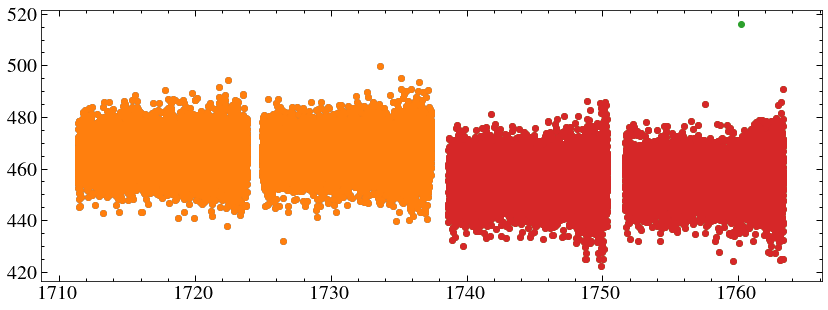

In [53]:
time = np.array([], dtype=float)
flux = np.array([], dtype=float)
fluxn = np.array([], dtype=float)
flux_error = np.array([], dtype=float)
flux_errorn = np.array([], dtype=float)
for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    plt.scatter(t, f)
    t, f, e = t[q==0], f[q==0], e[q==0]
    plt.scatter(t, f)
    time = np.concatenate((time, t))
    flux = np.concatenate((flux, f))
    flux_error = np.concatenate((flux_error, e))
    fit = np.polyval((np.polyfit(t,f,2)), t)
    fluxn = np.concatenate((fluxn, f/fit))
    flux_errorn = np.concatenate((flux_errorn, e/fit))
#plt.errorbar(time, flux, yerr=flux_error)
    

In [78]:
lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_error)
lcn = lk.LightCurve(time=time, flux=fluxn, flux_err=flux_errorn)

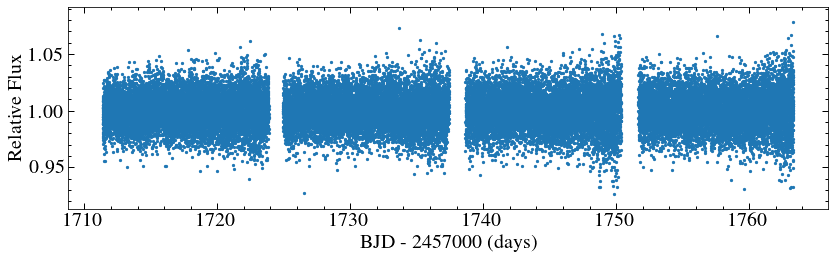

In [79]:
plt.figure(figsize=(12, 4))
plt.scatter(lcn.time, lcn.flux, s=5)
plt.xlabel('BJD - 2457000 (days)')
plt.ylabel('Relative Flux')
plt.tight_layout()
#plt.savefig('plots/gd394_tess_lc.pdf', dpi=150)

What is the fluff at 1750? Noise.

In [80]:
#plt.scatter(lcn.time, lcn.flux, s=5)
#plt.xlim(1748, 1751)

<Quantity 1.14643438 d>

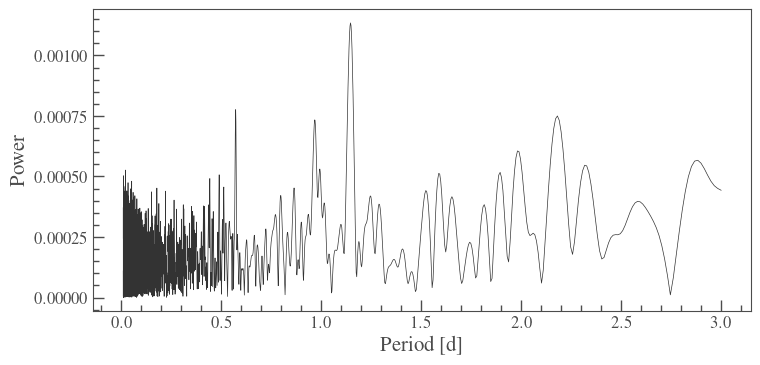

In [84]:
pgn = lcn.to_periodogram(oversample_factor=10,minimum_period=0.01*u.day, maximum_period=3*u.day)
pgn.plot()
#lcn.fold(1.1416479).bin(600).errorbar();
pgn.period_at_max_power

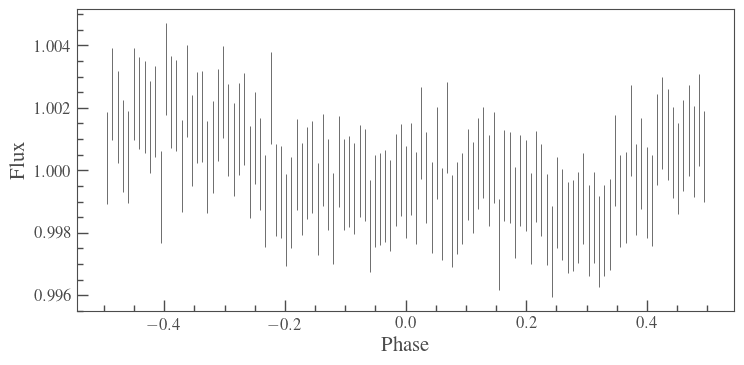

In [85]:
lcn.fold(pgn.period_at_max_power).bin(300).errorbar();

In [86]:
fitter = fitting.LevMarLSQFitter()

Parameter('x_0', value=1.145810743634027, unit=d) 0.0005511469762105944


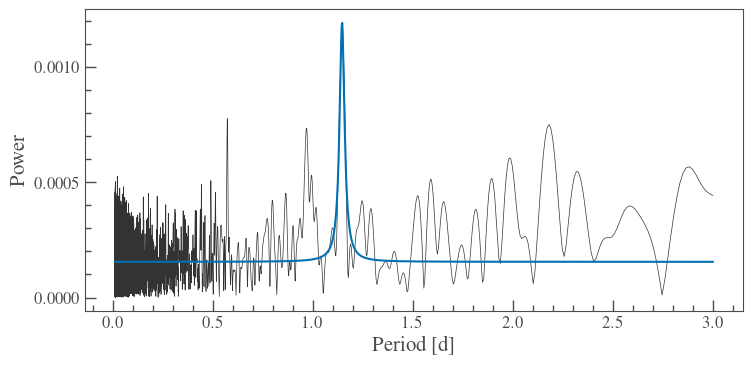

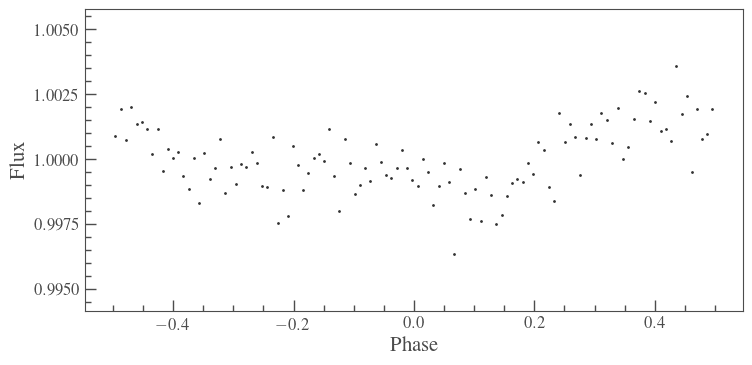

In [98]:
pgn.plot()
l_init =  models.Lorentz1D(0.4, 1.15, fwhm=0.01)+models.Const1D(0)
#mask = (pgn.period > 1.1*u.day) & (pgn.period < 1.2*u.day)
l_fit=fitter(l_init, pgn.period, pgn.power, maxiter=1000000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#print(l_fit[0].fwhm)
print(l_fit[0].x_0, fit_e[1])
plt.plot(pgn.period, l_fit(pgn.period))
plt.show()
peak_period = l_fit[0].x_0.value
lcn.fold(peak_period).bin(300).scatter();

In [99]:
np.mean(lc.flux)

460.75582841539335